In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filtered_panel = pd.read_csv(r'../data/processed/final_panel_data.csv')

In [3]:
filtered_panel

,financial_year,local_authority,size_category,value,removals,value_lag1,value_lag2,value_lag3
0,2015,adur,Large,0.9200,0,NaN,NaN,NaN
1,2016,adur,Large,1.0880,0,0.9200,NaN,NaN
2,2017,adur,Large,0.8005,0,1.0880,0.9200,NaN
3,2018,adur,Large,1.0820,0,0.8005,1.0880,0.920
4,2019,adur,Large,1.6580,0,1.0820,0.8005,1.088
...,...,...,...,...,...,...,...,...
7984,2019,york,Small,8.8070,24,11.1010,8.5040,7.809
7985,2020,york,Small,10.6730,11,8.8070,11.1010,8.504
7986,2021,york,Small,17.2610,19,10.6730,8.8070,11.101
7987,2022,york,Small,20.0350,17,17.2610,10.6730,8.807


In [4]:
test = filtered_panel.groupby('local_authority').size().reset_index(name="value")
test[test["value"]!=27]

,local_authority,value
126,isles of scilly,24


In [5]:
# ADF test on 'removals'
result_removals = adfuller(filtered_panel['removals'].dropna())
print("ADF Test for 'removals':")
print(f"ADF Statistic: {result_removals[0]}")
print(f"p-value: {result_removals[1]}")
print(f"Critical Values: {result_removals[4]}\n")

# ADF test on 'value'
result_value = adfuller(filtered_panel['value'].dropna())
print("ADF Test for 'value':")
print(f"ADF Statistic: {result_value[0]}")
print(f"p-value: {result_value[1]}")
print(f"Critical Values: {result_value[4]}")

ADF Test for 'removals':
ADF Statistic: -15.210535711106205
p-value: 5.66283906306167e-28
Critical Values: {'1%': np.float64(-3.4311723018698483), '5%': np.float64(-2.861903398224588), '10%': np.float64(-2.5669634321950032)}

ADF Test for 'value':
ADF Statistic: -9.266284227808267
p-value: 1.3642078081413022e-15
Critical Values: {'1%': np.float64(-3.4311726121946253), '5%': np.float64(-2.8619035353468147), '10%': np.float64(-2.5669635051866786)}


In [6]:
# Run Engle-Granger cointegration test
coint_stat, p_value, crit_values = coint(filtered_panel['removals'], filtered_panel['value'])

print(f"Engle-Granger Cointegration Test")
print(f"Test Statistic: {coint_stat}")
print(f"p-value: {p_value}")
print(f"Critical Values: {crit_values}")

Engle-Granger Cointegration Test
Test Statistic: -15.112156552630431
p-value: 6.4602891209649345e-27
Critical Values: [-3.89781157 -3.33689502 -3.04498099]


In [7]:
# Format data as a two-column array: [removals, value]
data = filtered_panel[['removals', 'value']].dropna()

# Run Granger causality test with up to 3 lags
grangercausalitytests(data, maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=59.4435 , p=0.0000  , df_denom=7985, df_num=1
ssr based chi2 test:   chi2=59.4658 , p=0.0000  , df=1
likelihood ratio test: chi2=59.2455 , p=0.0000  , df=1
parameter F test:         F=59.4435 , p=0.0000  , df_denom=7985, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=30.2393 , p=0.0000  , df_denom=7982, df_num=2
ssr based chi2 test:   chi2=60.5165 , p=0.0000  , df=2
likelihood ratio test: chi2=60.2884 , p=0.0000  , df=2
parameter F test:         F=30.2393 , p=0.0000  , df_denom=7982, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.5027 , p=0.0000  , df_denom=7979, df_num=3
ssr based chi2 test:   chi2=64.5648 , p=0.0000  , df=3
likelihood ratio test: chi2=64.3052 , p=0.0000  , df=3
parameter F test:         F=21.5027 , p=0.0000  , df_denom=7979, df_num=3


{np.int64(1): ({'ssr_ftest': (np.float64(59.44346128953314),
    np.float64(1.4102311481383351e-14),
    np.float64(7985.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(59.465794462215506),
    np.float64(1.2443834079752813e-14),
    np.int64(1)),
   'lrtest': (np.float64(59.24554356655426),
    np.float64(1.391751648991528e-14),
    np.int64(1)),
   'params_ftest': (np.float64(59.443461289535065),
    np.float64(1.4102311481369925e-14),
    np.float64(7985.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(30.239331101767633),
    np.float64(8.255211522046249e-14),
    np.float64(7982.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(60.516546607321),
    np.float64(7.227679268419274e-14),
    np.int64(2)),
   'lrtest': (np.float64(60.28843480460637),
    np.float64(8.100889736136512e-14),
    np.int64(2)),
   'params_ftest': (np.float64(30.239331101772045),
    np.float64(8.255211522005981e-14),
    np.float64(7982.0),
    2.0)},
   array([[0.

In [8]:
# Prepare data: ensure it's sorted and aligned
df = filtered_panel[['removals', 'value']].dropna().copy()
df = df.astype(float)

# Run Granger causality test: does 'removals' Granger-cause 'value'?
# maxlag = 3 for testing 1, 2, 3 lags
reverse_granger_results = grangercausalitytests(df[['value', 'removals']], maxlag=3, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=61.3314 , p=0.0000  , df_denom=7985, df_num=1
ssr based chi2 test:   chi2=61.3544 , p=0.0000  , df=1
likelihood ratio test: chi2=61.1200 , p=0.0000  , df=1
parameter F test:         F=61.3314 , p=0.0000  , df_denom=7985, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.2068 , p=0.0000  , df_denom=7982, df_num=2
ssr based chi2 test:   chi2=20.4263 , p=0.0000  , df=2
likelihood ratio test: chi2=20.4002 , p=0.0000  , df=2
parameter F test:         F=10.2068 , p=0.0000  , df_denom=7982, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5660  , p=0.0034  , df_denom=7979, df_num=3
ssr based chi2 test:   chi2=13.7099 , p=0.0033  , df=3
likelihood ratio test: chi2=13.6981 , p=0.0033  , df=3
parameter F test:         F=4.5660  , p=0.0034  , df_denom=7979, df_num=3


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [9]:
# Run OLS regression with fixed effects for LA and year
model = smf.ols(
    formula='removals ~ value + C(local_authority) + C(financial_year) + C(size_category)+value:C(size_category)',
    data=filtered_panel
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               removals   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     52.50
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:47:53   Log-Likelihood:                -21963.
No. Observations:                7989   AIC:                         4.454e+04
Df Residuals:                    7680   BIC:                         4.670e+04
Df Model:                         308                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [10]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                            &     removals     & \textbf{  R-squared:         } &     0.678   \\
\textbf{Model:}                                                    &       OLS        & \textbf{  Adj. R-squared:    } &     0.665   \\
\textbf{Method:}                                                   &  Least Squares   & \textbf{  F-statistic:       } &     52.50   \\
\textbf{Date:}                                                     & Sat, 23 Aug 2025 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                                                     &     20:47:53     & \textbf{  Log-Likelihood:    } &   -21963.   \\
\textbf{No. Observations:}                                         &        7989      & \textbf{  AIC:               } & 4.454e+04   \\
\textbf{Df Residuals:}                                             &        7680      & \textbf{  BIC:               } & 4.670e+04   \\
\t

In [11]:
model = smf.ols(
    formula=(
        'removals ~ '
        'value + value_lag1 + value_lag2 + value_lag3 + '
        'C(local_authority) + C(financial_year) + C(size_category) + '
        'value:C(size_category) + '
        'value_lag1:C(size_category) + '
        'value_lag2:C(size_category) + '
        'value_lag3:C(size_category)'
    ),
    data=filtered_panel
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               removals   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     36.64
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:47:53   Log-Likelihood:                -14638.
No. Observations:                5322   AIC:                         2.991e+04
Df Residuals:                    5007   BIC:                         3.198e+04
Df Model:                         314                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [12]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                            &     removals     & \textbf{  R-squared:         } &     0.697   \\
\textbf{Model:}                                                    &       OLS        & \textbf{  Adj. R-squared:    } &     0.678   \\
\textbf{Method:}                                                   &  Least Squares   & \textbf{  F-statistic:       } &     36.64   \\
\textbf{Date:}                                                     & Sat, 23 Aug 2025 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                                                     &     20:47:53     & \textbf{  Log-Likelihood:    } &   -14638.   \\
\textbf{No. Observations:}                                         &        5322      & \textbf{  AIC:               } & 2.991e+04   \\
\textbf{Df Residuals:}                                             &        5007      & \textbf{  BIC:               } & 3.198e+04   \\
\t

In [13]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error

# ----------------------------
# Step 1: Ensure consistent categorical dtype
# ----------------------------
filtered_panel['financial_year'] = pd.Categorical(
    filtered_panel['financial_year'],
    categories=sorted(filtered_panel['financial_year'].unique())
)
filtered_panel['local_authority'] = pd.Categorical(
    filtered_panel['local_authority'],
    categories=sorted(filtered_panel['local_authority'].unique())
)
filtered_panel['size_category'] = pd.Categorical(
    filtered_panel['size_category'],
    categories=sorted(filtered_panel['size_category'].unique())
)

# ----------------------------
# Step 2: Stratified 70/30 split within each financial year
# ----------------------------
train_list = []
test_list = []

for year in filtered_panel['financial_year'].cat.categories:
    year_data = filtered_panel[filtered_panel['financial_year'] == year]
    if len(year_data) > 1:
        train_split, test_split = train_test_split(
            year_data, test_size=0.3, random_state=42
        )
        train_list.append(train_split)
        test_list.append(test_split)
    else:
        train_list.append(year_data)

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)

# ----------------------------
# Step 3: Clean test set — drop rows with missing lag values
# ----------------------------
required_vars = [
    'value', 'value_lag1', 'value_lag2', 'value_lag3',
    'local_authority', 'financial_year', 'size_category'
]

test_data_clean = test_data.dropna(subset=required_vars).copy()

# Match categories between train and test
for col in ['financial_year', 'local_authority', 'size_category']:
    test_data_clean[col] = pd.Categorical(
        test_data_clean[col],
        categories=train_data[col].cat.categories
    )

# ----------------------------
# Step 4: Fit the model
# ----------------------------
train_model = smf.ols(
    formula=(
        'removals ~ '
        'value + value_lag1 + value_lag2 + value_lag3 + '
        'C(local_authority) + C(financial_year) + C(size_category) + '
        'value:C(size_category) + '
        'value_lag1:C(size_category) + '
        'value_lag2:C(size_category) + '
        'value_lag3:C(size_category)'
    ),
    data=train_data
).fit()

# ----------------------------
# Step 5: Predict and evaluate
# ----------------------------
y_pred = train_model.predict(test_data_clean)
y_true = test_data_clean['removals']

print("Test R-squared:", r2_score(y_true, y_pred))
print("Test RMSE:", mean_squared_error(y_true, y_pred) ** 0.5)
print("Training R-squared:", train_model.rsquared)



Test R-squared: 0.3503557227813121
Test RMSE: 5.9159145307103245
Training R-squared: 0.7546568511069864


In [14]:
top10_removals = filtered_panel.sort_values('removals', ascending=False).head(30)
print(top10_removals[['local_authority', 'financial_year', 'removals', 'value', 'size_category']])

      local_authority financial_year  removals    value size_category
7579      westminster           2019        71   23.431         Small
4743  north yorkshire           2018        70    7.503         Small
4746  north yorkshire           2021        69    6.349         Small
4741  north yorkshire           2016        66    8.831         Small
4744  north yorkshire           2019        64    9.843         Small
4747  north yorkshire           2022        62    8.708         Small
211            barnet           2019        60   11.125         Small
427        birmingham           2019        58   70.092         Small
5766         somerset           2015        55    7.729         Small
5772         somerset           2021        54    9.027         Small
1129           camden           2019        52   65.115         Small
7660        wiltshire           2019        52   15.853         Small
429        birmingham           2021        51  122.030         Small
1563         cornwal

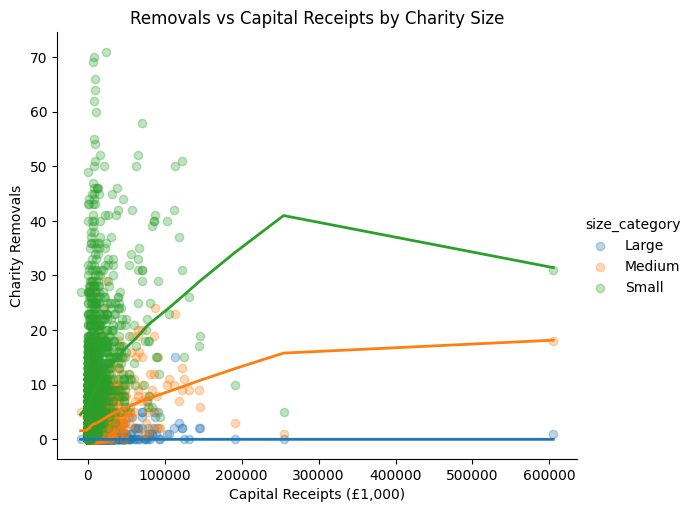

In [15]:
filtered_panel_1 = filtered_panel.copy()
filtered_panel_1['value_thousands'] = filtered_panel_1['value'] * 1000

sns.lmplot(
    data=filtered_panel_1,
    x='value_thousands', y='removals',
    hue='size_category',  # group by charity size
    lowess=True,
    scatter_kws={'alpha':0.3},
    line_kws={'linewidth':2},
    height=5, aspect=1.2
)

plt.xlabel('Capital Receipts (£1,000)')
plt.ylabel('Charity Removals')
plt.title('Removals vs Capital Receipts by Charity Size')
plt.show()

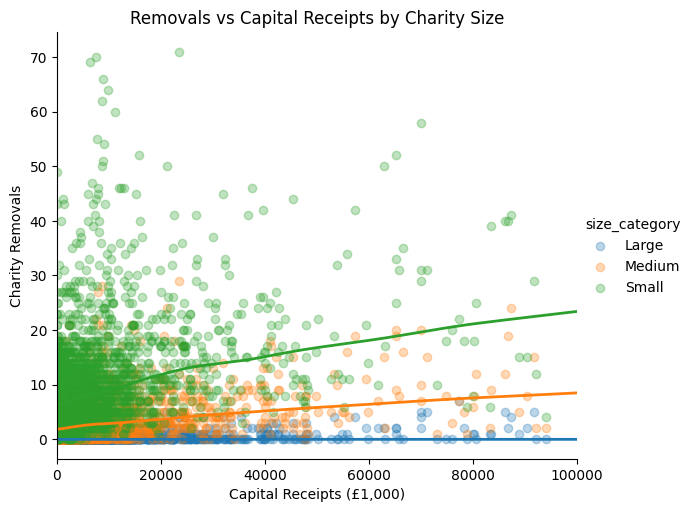

In [16]:
sns.lmplot(
    data=filtered_panel_1,
    x='value_thousands', y='removals',
    hue='size_category',
    lowess=True,
    scatter_kws={'alpha':0.3},
    line_kws={'linewidth':2},
    height=5, aspect=1.2
)

plt.xlabel('Capital Receipts (£1,000)')
plt.ylabel('Charity Removals')
plt.title('Removals vs Capital Receipts by Charity Size')
plt.xlim(0, 100000)  # limit to £100 million
plt.show()


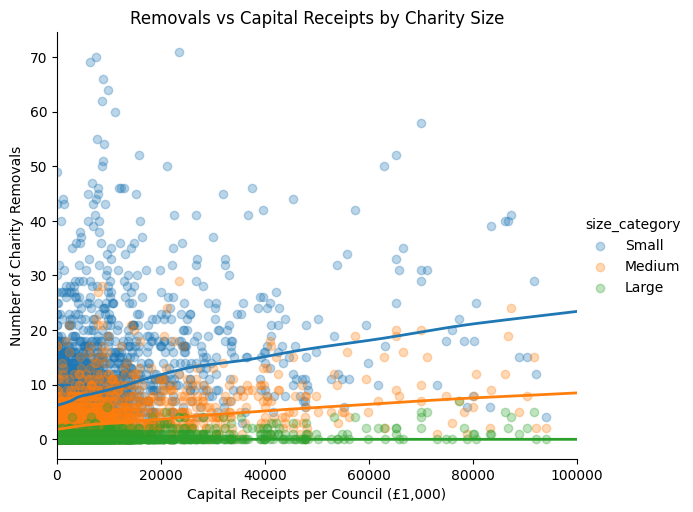

In [17]:
sns.lmplot(
    data=filtered_panel_1,
    x='value_thousands', y='removals',
    hue='size_category',
    hue_order=['Small', 'Medium', 'Large'],  # green on top, then orange, then blue
    lowess=True,
    scatter_kws={'alpha': 0.3},
    line_kws={'linewidth': 2},
    height=5, aspect=1.2
)
plt.xlabel('Capital Receipts per Council (£1,000)')
plt.ylabel('Number of Charity Removals')
plt.title('Removals vs Capital Receipts by Charity Size')
plt.xlim(0, 100000)
plt.show()

In [18]:
# Create lag 4 and lag 5 within each local_authority & size_category
filtered_panel["value_lag4"] = (
    filtered_panel
    .groupby(["local_authority", "size_category"])["value"]
    .shift(4)
)

filtered_panel["value_lag5"] = (
    filtered_panel
    .groupby(["local_authority", "size_category"])["value"]
    .shift(5)
)

C:\Users\User\AppData\Local\Temp\ipykernel_15872\2288109909.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["local_authority", "size_category"])["value"]
C:\Users\User\AppData\Local\Temp\ipykernel_15872\2288109909.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["local_authority", "size_category"])["value"]


In [19]:
model = smf.ols(
    formula=(
        'removals ~ '
        'value + value_lag1 + value_lag2 + value_lag3 + value_lag4 + value_lag5 + '
        'C(local_authority) + C(financial_year) + C(size_category) + '
        'value:C(size_category) + '
        'value_lag1:C(size_category) + '
        'value_lag2:C(size_category) + '
        'value_lag3:C(size_category) + '
        'value_lag4:C(size_category) + '
        'value_lag5:C(size_category)'
    ),
    data=filtered_panel
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               removals   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     22.56
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:48:21   Log-Likelihood:                -9518.3
No. Observations:                3549   AIC:                         1.967e+04
Df Residuals:                    3230   BIC:                         2.164e+04
Df Model:                         318                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [22]:
model = smf.ols(
    formula=(
        'removals ~ '
        'value + value_lag1 + value_lag2 + value_lag3 + value_lag4 + '
        'C(local_authority) + C(financial_year) + C(size_category) + '
        'value:C(size_category) + '
        'value_lag1:C(size_category) + '
        'value_lag2:C(size_category) + '
        'value_lag3:C(size_category) + '
        'value_lag4:C(size_category)'
    ),
    data=filtered_panel
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               removals   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     30.62
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:05:45   Log-Likelihood:                -12191.
No. Observations:                4437   AIC:                         2.502e+04
Df Residuals:                    4120   BIC:                         2.704e+04
Df Model:                         316                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------